# Loan Default Prediction
### Hubert, Kevin, Joseph, Ankita
### About
This is our final project for ECS111. Our goal is to create a model that can accurately and efficiently predict whether someone will default their loan, utilizing information from their credit history and other metrics

### Dataset
The data is collected through an online Kaggle Competition [shown here](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)

In [43]:
# import packages
# processing
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

#system
import os

In [44]:
# load data
application_records = pd.read_csv('application_record.csv.zip',compression='zip')
credit_records = pd.read_csv('credit_record.csv.zip',compression='zip')

In [45]:
application_records.head()

#'ID': client number
#'CODE_GENDER': gender 
#'FLAG_OWN_CAR': has car? 
#'FLAG_OWN_REALTY': property? 
#'CNT_CHILDREN': number of children
#'AMT_INCOME_TOTAL': annual income 
#'NAME_INCOME_TYPE': type of income 
#'NAME_EDUCATION_TYPE': education level
#'NAME_FAMILY_STATUS': marital status 
#'NAME_HOUSING_TYPE': way of living
#'DAYS_BIRTH': birthday?????
#'DAYS_EMPLOYED': start date?????
#'FLAG_MOBIL': has mobile phone? 
#'FLAG_WORK_PHONE': has work phone?
#'FLAG_PHONE': has phone?
# 'FLAG_EMAIL': has email? 
#'OCCUPATION_TYPE': occupation 
#'CNT_FAM_MEMBERS':family size

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [46]:
application_records.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [47]:
credit_records

#'ID': client number
#'MONTHS_BALANCE': record months, 
#'STATUS':
# C means loan is closed or paid off
# X means no loan for the month
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [48]:
#inner join to only get data present in both tables
merged_data = pd.merge(application_records, credit_records, on='ID', how='inner')
merged_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


### Check for/ Remove NA Values

In [49]:
merged_data.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

In [50]:
merged_data['OCCUPATION_TYPE'].fillna(value="None",inplace=True)

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_12449/2136190221.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['OCCUPATION_TYPE'].fillna(value="None",inplace=True)


In [51]:
merged_data.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
dtype: int64

### Feature Encoding/Engineering
CODE_GENDER: 2 categories (no ordinal)

FLAG_OWN_CAR: 2 categories (no ordinal)

FLAG_OWN_REALTY: 2 categories (no ordinal)

NAME_INCOME_TYPE: 5 categories (could have ordering??)

NAME_EDUCATION_TYPE: 5 categories (should have ordering, some more important than others)

NAME_FAMILY_STATUS: 5 categories (could have ordering?)

NAME_HOUSING_TYPE: 6 categories (could have ordering??)

In [52]:
md = merged_data.copy()

In [53]:
merged_data = md.copy()

In [54]:
merged_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0,-4,C


In [55]:
#change all categories with only two categories to 0s and 1s
le = LabelEncoder()
two_categories_cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
for col in two_categories_cols:
	merged_data[col] = le.fit_transform(merged_data[col])
merged_data.head()

#option 1: try one hot encoding for remaining features
#one_hot_cols = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
#merged_data = pd.get_dummies(merged_data,columns=one_hot_cols,dtype=int)

#option 2: try binary encoding
binary_encode_cols = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
encoder = BinaryEncoder(cols = binary_encode_cols,return_df=True)
merged_data = encoder.fit_transform(merged_data)				 

In [56]:
merged_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE_0,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_EDUCATION_TYPE_0,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE_0,OCCUPATION_TYPE_1,OCCUPATION_TYPE_2,OCCUPATION_TYPE_3,OCCUPATION_TYPE_4,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,1,1,1,0,427500.0,0,0,1,0,...,0,0,0,0,0,0,1,2.0,0,C
1,5008804,1,1,1,0,427500.0,0,0,1,0,...,0,0,0,0,0,0,1,2.0,-1,C
2,5008804,1,1,1,0,427500.0,0,0,1,0,...,0,0,0,0,0,0,1,2.0,-2,C
3,5008804,1,1,1,0,427500.0,0,0,1,0,...,0,0,0,0,0,0,1,2.0,-3,C
4,5008804,1,1,1,0,427500.0,0,0,1,0,...,0,0,0,0,0,0,1,2.0,-4,C


In [57]:
#encode target feature
## Target Variable, 'STATUS' column ## (easier to identify overdue payments)

# Simplify the target variable: 1 for overdue payments, 0 for paid off loans
# C means loan is closed or paid off
# X means no loan for the month
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days

merged_data['Target'] = merged_data['STATUS'].apply(lambda x: 0 if x in ['C', 'X'] else 1)
merged_data.drop(['STATUS','ID','FLAG_MOBIL'],axis=1,inplace=True)


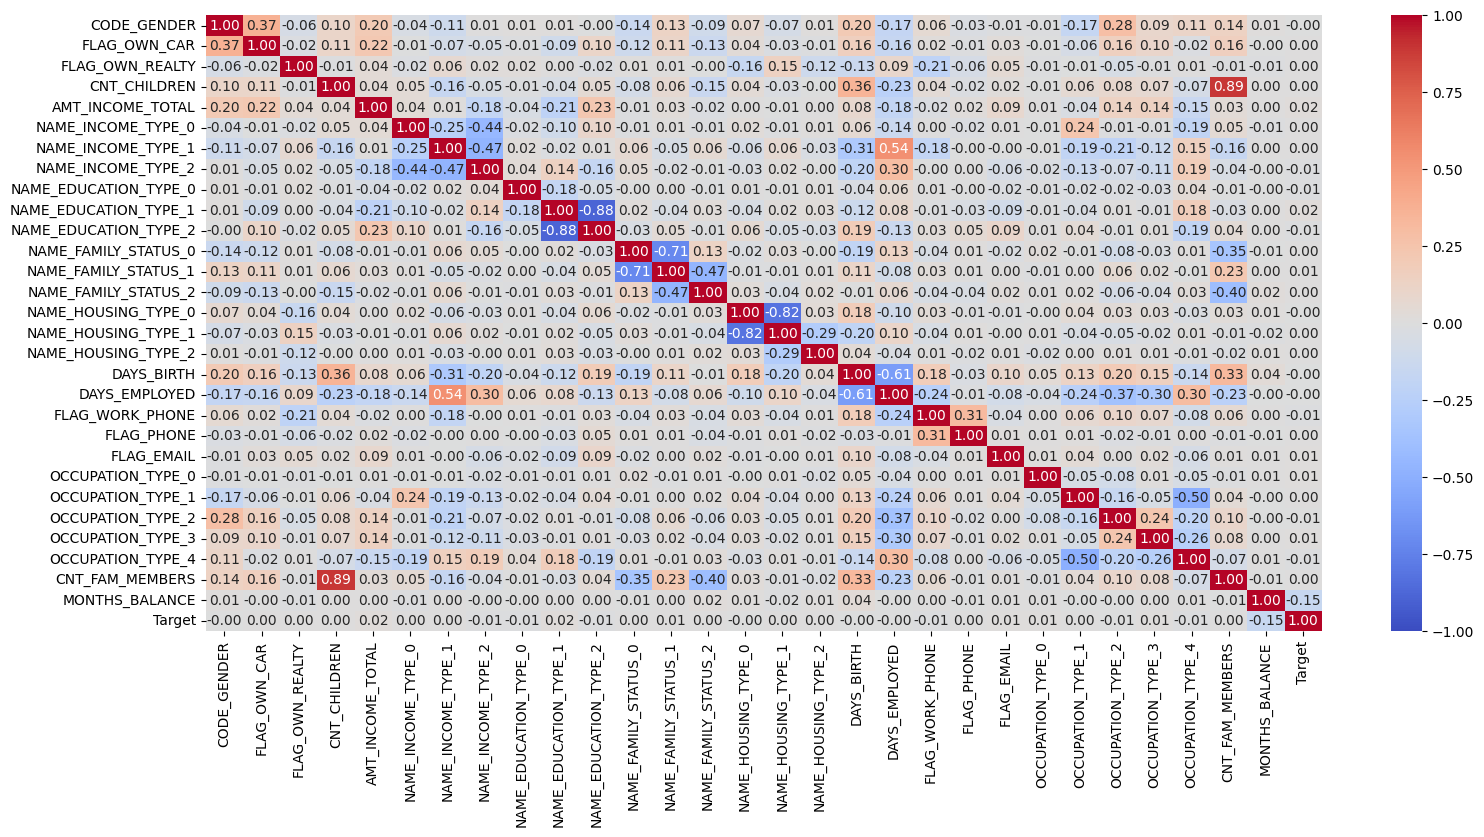

In [58]:
plt.figure(figsize=(18,8))
corr_matrix = merged_data.corr()
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt=".2f",vmin=-1,center=0)
plt.show()

### Modeling

In [59]:
X = merged_data.drop(['Target'],axis=1)
features = X.columns
y = merged_data['Target']

In [60]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CODE_GENDER            777715 non-null  int64  
 1   FLAG_OWN_CAR           777715 non-null  int64  
 2   FLAG_OWN_REALTY        777715 non-null  int64  
 3   CNT_CHILDREN           777715 non-null  int64  
 4   AMT_INCOME_TOTAL       777715 non-null  float64
 5   NAME_INCOME_TYPE_0     777715 non-null  int64  
 6   NAME_INCOME_TYPE_1     777715 non-null  int64  
 7   NAME_INCOME_TYPE_2     777715 non-null  int64  
 8   NAME_EDUCATION_TYPE_0  777715 non-null  int64  
 9   NAME_EDUCATION_TYPE_1  777715 non-null  int64  
 10  NAME_EDUCATION_TYPE_2  777715 non-null  int64  
 11  NAME_FAMILY_STATUS_0   777715 non-null  int64  
 12  NAME_FAMILY_STATUS_1   777715 non-null  int64  
 13  NAME_FAMILY_STATUS_2   777715 non-null  int64  
 14  NAME_HOUSING_TYPE_0    777715 non-nu

In [61]:
## Logistic Model ##
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct = make_column_transformer(
	(StandardScaler(),features),
    #(MinMaxScaler(),features),
    remainder='passthrough'
	)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [62]:
merged_data['Target'].value_counts()

Target
0    475486
1    302229
Name: count, dtype: int64

Accuracy: 0.6286750287701793
              precision    recall  f1-score   support

           0       0.63      0.93      0.75     95255
           1       0.58      0.16      0.25     60288

    accuracy                           0.63    155543
   macro avg       0.61      0.54      0.50    155543
weighted avg       0.61      0.63      0.56    155543



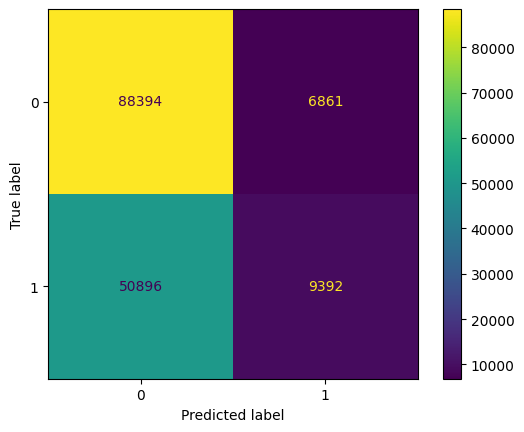

In [63]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix)
disp.plot()


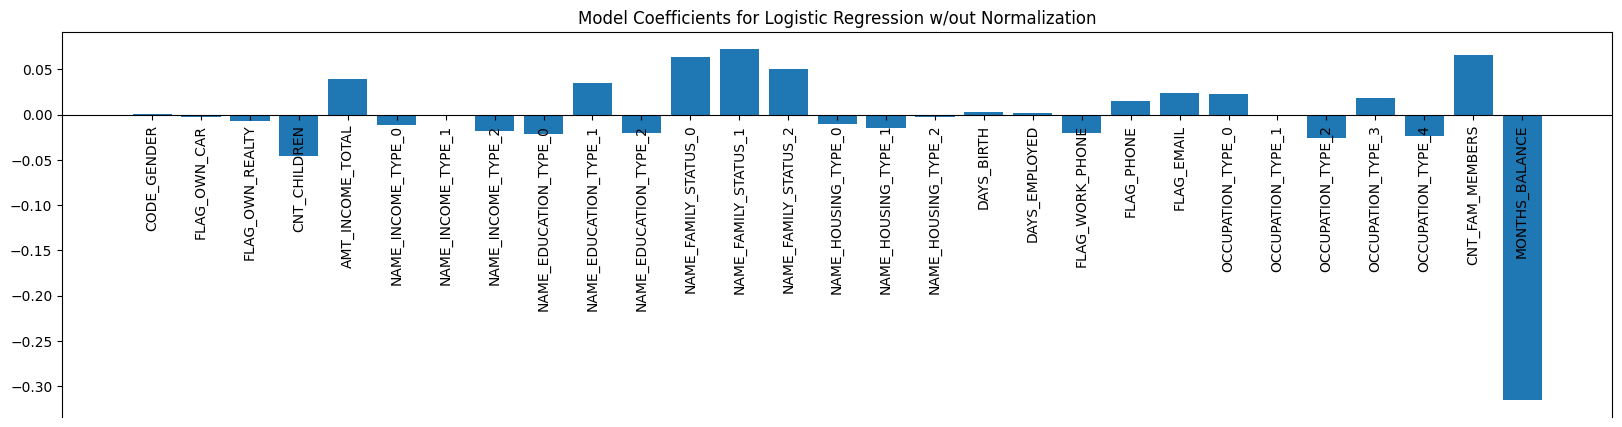

In [64]:
def graph_coefficients(model,model_name,features):
	lreg_coefficients = pd.DataFrame()
	lreg_coefficients['Columns'] = features
	lreg_coefficients['Coefficient Estimate'] = pd.Series(model.coef_[0])
	fig, ax = plt.subplots(figsize=(20, 5))
	ax.bar(lreg_coefficients["Columns"], lreg_coefficients['Coefficient Estimate'])

	ax.spines['bottom'].set_position('zero')
	plt.xticks(rotation=90)
	plt.title(f"Model Coefficients for {model_name} w/out Normalization")
	plt.style.use('ggplot')
	plt.show()
graph_coefficients(logreg,"Logistic Regression",features=features)